This is part of the [geonewb](https://bitsofanalytics.org/posts/geonewb-intro/) series of posts.

In [Part 2](https://bitsofanalytics.org/posts/algaebloom-part2/) of this series we got familiar with Microsoft's Planetary computer and learned a bit about Sentinel-2 image files. Now we'll move on in the tutorial to exploring:

- **programmatically finding and acquiring satellite image data based on location and date range** (both Sentinel-2 and Landsat) from **Microsoft's Planetary Computer**,
- using GeoPandas for working with multiple image items

As mentioned in the Part 1, I'm following along and taking some deeper dives and various detours from the official [Getting Started Tutorial](https://drivendata.co/blog/tick-tick-bloom-benchmark).

In subsequent parts we'll tackle the **feature engineering** and **predictive modeling** sections of the original tutorial.

In [1]:
# Need to do some date math and need to work with file paths
from datetime import timedelta, datetime
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from IPython.display import Image
from PIL import Image as PILImage

In [4]:
%matplotlib inline

# Finding and acquiring satellite imagery data
Unline many challenges at [DrivenData](https://www.drivendata.org/), the feature data for this challenge is not directly provided. We need to get it using various APIs from specific sources. The date and location for each `uid` in the metadata can be used to find relevant satellite images from a number of different places. There are four approved data sources and all the details are described on the project home page at the following links:

- [Sentinel-2 satellite imagery](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#sentinel-2-1)
- [Landsat satellite imagery](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#landsat-1)
- [NOAA's High-Resolution Rapid Refresh (HRRR) climate data](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#climate-data-1)
- [Copernicus DEM elevation data](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#elevation-data-1)

For now we will just focus on finding relevant Sentinel-2 and Landsat data. This [page in the challenge site](https://www.drivendata.org/competitions/143/tick-tick-bloom/page/650/#satellite-imagery) has additional information and resources related to retrieving satellite imagery data. From that page you can get a very good high level overview of the different *levels* of satellite imagery data, top of atmosphere reflectance vs bottom of atmosphere reflectance, atmospheric corrections, spectral bands and algorithmic bands, as well as the relevant links for accessing data from the MPC.

From the main tutorial:

> The general steps we'll use to pull satellite data are:
>
>    1. Establish a connection to the Planetary Computer's STAC API using the planetary_computer and pystac_client Python packages.
>
>    2. Query the STAC API for scenes that capture our in situ labels. For each sample, we'll search for imagery that includes the sample's location (latitude and longitude) around the date the sample was taken. In this benchmark, we'll use only Sentinel-2 L2A and Landsat Level-2 data.
>
>    3. Select one image for each sample. We'll use Sentinel-2 data wherever it is available, because it is higher resolution. We'll have to use Landsat for data before roughly 2016, because Sentinel-2 was not available yet.
>
>    4. Convert the image to a 1-dimensional list of features that can be input into our tree model

# Code driven search for images with the STAC API

In Part 2, we manually used the MPC Explore feature to find an image of interest. Now, we'll use a lat-long pair along with a date range to find all the images available for that location at that time. For the lat-long value of interest I picked out a point in the little body of water outlined below.

In [5]:
Image(url='images/thunder_bay_lake_point_labelled.png')

In [6]:
lat = 45.03967636446461
long = -83.30284787280465

In [7]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

# Useful libs for working with this data
import geopy.distance as distance
import geopandas as gpd
import shapely
import rioxarray

Let's create a few functions to make it easy to define a bounding box around a lat, long pair. This code is right from the tutorial.

> Time range: We want our feature data to be as close to the time of the sample as possible, because in algal blooms in small water bodies form and move very rapidly. Remember, you cannot use any data collected after the date of the sample.

> Imagery taken with roughly 10 days of the sample will generally still be an accurate representation of environmental conditions at the time of the sample. For some data points you may not be able to get data within 10 days, and may have to use earlier data. We'll search the fifteen days up to the sample time, including the sample date.


In [8]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=1000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [9]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=10):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

In [10]:
target_date = "2022-06-15"

In [11]:
target_date_range = get_date_range(target_date)
target_date_range

'2022-06-05T/2022-06-15T'

This next step essentially "signs in" to the MPC catalog of data so that we can search and acquire the data we are interested in.

In [12]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

catalog

<Client id=microsoft-pc>

To search the catalog we will supply three different types of criteria:

- which collections to search (e.g. "sentinel-2-l2a")
- a bounding box of coordinates
- a date range

Any item with the specified collection(s), that intersect the bounding box and were acquired within the date range will be returned.

In [13]:
#help(Client.search)

In [14]:
bbox = get_bounding_box(lat, long, meter_buffer=3000)
bbox

[-83.34092260849519, 45.01268150971338, -83.2647731371141, 45.06667109107233]

In [15]:
# search the planetary computer sentinel-l2a and Landsat level 2
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=target_date_range
)

# see how many items were returned
items = search.get_all_items()
print(f'{len(items)} items found')
print(f'items is a {type(items)}')
print(f'items[0] is a {type(items[0])}')

17 items found
items is a <class 'pystac.item_collection.ItemCollection'>
items[0] is a <class 'pystac.item.Item'>


Great, it worked. By looking at the `id` values, we can see how many Sentinel-2 vs Landsat images we found.

In [16]:
for item in items:
    print(item.id)

S2B_MSIL2A_20220613T161829_R040_T17TLL_20220614T113426
S2B_MSIL2A_20220613T161829_R040_T17TLK_20220614T110341
S2B_MSIL2A_20220613T161829_R040_T16TGR_20220614T112541
S2B_MSIL2A_20220613T161829_R040_T16TGQ_20220614T112402
LC09_L2SP_020029_20220612_02_T1
S2A_MSIL2A_20220611T162911_R083_T17TLL_20220612T151658
S2A_MSIL2A_20220611T162911_R083_T16TGR_20220612T145248
LC08_L2SP_021029_20220611_02_T1
LC08_L2SP_021028_20220611_02_T1
S2A_MSIL2A_20220608T161841_R040_T17TLL_20220609T103649
S2A_MSIL2A_20220608T161841_R040_T17TLK_20220609T095528
S2A_MSIL2A_20220608T161841_R040_T16TGR_20220609T105106
S2A_MSIL2A_20220608T161841_R040_T16TGQ_20220609T103242
S2B_MSIL2A_20220606T162839_R083_T17TLL_20220607T020323
S2B_MSIL2A_20220606T162839_R083_T17TLK_20220607T023733
S2B_MSIL2A_20220606T162839_R083_T16TGR_20220607T015546
S2B_MSIL2A_20220606T162839_R083_T16TGQ_20220607T015218


Look at the properties for a Sentinel-2 item and a Landsat item.

In [17]:
# Sentinel-2 item
items[0].properties

{'datetime': '2022-06-13T16:18:29.024000Z',
 'platform': 'Sentinel-2B',
 'proj:epsg': 32617,
 'instruments': ['msi'],
 's2:mgrs_tile': '17TLL',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2B_OPER_MSI_L2A_TL_ESRI_20220614T113427_A027522_T17TLL_N04.00',
 'eo:cloud_cover': 87.161016,
 's2:datatake_id': 'GS2B_20220613T161829_027522_N04.00',
 's2:product_uri': 'S2B_MSIL2A_20220613T161829_N0400_R040_T17TLL_20220614T113426.SAFE',
 's2:datastrip_id': 'S2B_OPER_MSI_L2A_DS_ESRI_20220614T113427_S20220613T162212_N04.00',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2022-06-14T11:34:26.294534Z',
 'sat:relative_orbit': 40,
 's2:water_percentage': 6.461042,
 's2:mean_solar_zenith': 25.4829228231717,
 's2:mean_solar_azimuth': 146.024549969213,
 's2:processing_baseline': '04.00',
 's2:snow_ice_percentage': 0.0,
 's2:vegetation_percentage': 6.113103,
 's2:thin_cirrus_percentage': 33.120424,
 's2:cloud_shadow_percentage'

In [18]:
# Landsat item
items[4].properties

{'gsd': 30,
 'created': '2022-06-28T23:39:39.840750Z',
 'sci:doi': '10.5066/P9OGBGM6',
 'datetime': '2022-06-12T16:15:20.609822Z',
 'platform': 'landsat-9',
 'proj:epsg': 32617,
 'proj:shape': [8001, 7901],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['oli', 'tirs'],
 'eo:cloud_cover': 79.41,
 'proj:transform': [30.0, 0.0, 245685.0, 0.0, -30.0, 5060415.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '029',
 'landsat:scene_id': 'LC90200292022163LGN00',
 'landsat:wrs_path': '020',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 138.06479334,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 63.60158079,
 'landsat:cloud_cover_land': 86.06,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T1'}

Yep, some of the assets are different, though some are shared. Down below we'll see that we'll need to process the Landsat assets differently that we do the Sentinel-2 assets:

- Sentinel-2 contains a 'visual' band that includes the red, green, and blue bands
- Landsat has individual red, green and blue bands, but not aconvenient 'visual' band
- From the `crop_landsat_image()` function in the tutorial, it looks Landsat rgb values need to be normalized to 0-255 to be consistent with Sentinel-2.
- That same function uses `odc.stac.load()` instead of `rioxarray`.
- The `gsd` property of the Landsat item indicates that the resolution is 30m. Sentinel-2 gives us 10m resolution for several of the bands.

# Do items contain our sample point? Spatial queries with geopandas.

From the original tutorial (yes, we are using a different point and different target date):

> Remember that our example measurement was taken on 2021-09-27 at coordinates (41.98006, -110.65734). Because we used a bounding box around the sample to search, the Planetary Computer returned all items that contain any part of that bounding box. This means we still have to double check whether each item actually contains our sample point.

We will use GeoPandas to create a `GeoDataFrame` based on the collection of STAC items. This will allow us to do spatial queries such as checking if each item contains our sample point (a lat-long pair) - though it appears in the tutorial that a subset of this `GeoDataFrame` is converted to a pandas `DataFrame` and then the lat-long sample point value is manually checked to see if it's in the bounding box. Seems like there must be a GeoPandas way to do the same.

What exactly is GeoPandas again? The basic idea is to combine the capabilites of pandas with the shapely library to allow you to work with geospatial data in a pandas-like way. 

> GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by [shapely]()https://shapely.readthedocs.io/en/stable/index.html. GeoPandas further depends on [fiona](https://fiona.readthedocs.io/) for file access and matplotlib for plotting.

Conventiently, you can create a `GeoDataFrame` from the features dictionary returned by the STAC items collection's `to_dict` method. 

In [19]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
items_df.head()

,geometry,datetime,platform,proj:epsg,instruments,s2:mgrs_tile,constellation,s2:granule_id,eo:cloud_cover,s2:datatake_id,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-83.52837 45.03720, -83.50498 45.106...",2022-06-13T16:18:29.024000Z,Sentinel-2B,32617,[msi],17TLL,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20220614T113427_A0275...,87.161016,GS2B_20220613T161829_027522_N04.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-83.53807 45.00860, -83.50498 45.106...",2022-06-13T16:18:29.024000Z,Sentinel-2B,32617,[msi],17TLK,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20220614T110342_A0275...,95.372748,GS2B_20220613T161829_027522_N04.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((-83.53731 45.01084, -83.50498 45.106...",2022-06-13T16:18:29.024000Z,Sentinel-2B,32616,[msi],16TGR,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20220614T112542_A0275...,99.999827,GS2B_20220613T161829_027522_N04.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((-83.83576 44.11947, -83.80033 44.226...",2022-06-13T16:18:29.024000Z,Sentinel-2B,32616,[msi],16TGQ,Sentinel 2,S2B_OPER_MSI_L2A_TL_ESRI_20220614T112404_A0275...,99.957287,GS2B_20220613T161829_027522_N04.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-83.56556 45.66118, -84.14055 43.950...",2022-06-12T16:15:20.609822Z,landsat-9,32617,"[oli, tirs]",NaN,NaN,NaN,79.410000,NaN,...,029,LC90200292022163LGN00,020,2,138.064793,L2SP,63.601581,86.06,02,T1


In [20]:
items_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 17 non-null     geometry
 1   datetime                                 17 non-null     object  
 2   platform                                 17 non-null     object  
 3   proj:epsg                                17 non-null     int64   
 4   instruments                              17 non-null     object  
 5   s2:mgrs_tile                             14 non-null     object  
 6   constellation                            14 non-null     object  
 7   s2:granule_id                            14 non-null     object  
 8   eo:cloud_cover                           17 non-null     float64 
 9   s2:datatake_id                           14 non-null     object  
 10  s2:product_uri                  

Looks like there are clearly two different groups of images - fourteen Sentinel-2 images and three Landsat images. Let's confirm by using the pandas-like capabilities of GeoPandas.

The `geometry` column has a `geometry` data type (a GeoPandas thing) and the values are POLYGON objects from the shapely library.

In [21]:
items_df.groupby(['platform'])[['platform']].count()

,platform
platform,
Sentinel-2A,6
Sentinel-2B,8
landsat-8,2
landsat-9,1


In [22]:
items_df.groupby(['platform'])[['platform', 's2:mgrs_tile', 'gsd']].count()

,platform,s2:mgrs_tile,gsd
platform,,,
Sentinel-2A,6,6,0
Sentinel-2B,8,8,0
landsat-8,2,0,2
landsat-9,1,0,1


One of the advantages of GeoPandas is that we can do spatial queries.

In [23]:
# Create a shapely Point object using the lat-long coordinates of interest
sample_point = shapely.geometry.Point((long, lat))

We can use `contains()` to check of the sample point is contained within the `geometry` object of each row in the `GeoDataFrame`. We'll add a new boolean column which indicates whether or not GeoPandas classifies each row as containing the sample point.

In [24]:
items_df['gpd_contains_point'] = items_df['geometry'].contains(sample_point)
items_df[['geometry', 'gpd_contains_point']]

,geometry,gpd_contains_point
0,"POLYGON ((-83.52837 45.03720, -83.50498 45.106...",False
1,"POLYGON ((-83.53807 45.00860, -83.50498 45.106...",True
2,"POLYGON ((-83.53731 45.01084, -83.50498 45.106...",True
3,"POLYGON ((-83.83576 44.11947, -83.80033 44.226...",True
4,"POLYGON ((-83.56556 45.66118, -84.14055 43.950...",True
5,"POLYGON ((-82.14621 45.08712, -82.15765 45.059...",False
6,"POLYGON ((-84.41644 46.02437, -83.00067 45.983...",True
7,"POLYGON ((-85.12959 45.66361, -85.70455 43.952...",True
8,"POLYGON ((-84.62940 47.08717, -85.22759 45.378...",True
9,"POLYGON ((-83.51840 45.03736, -83.48218 45.144...",False


Great. Now let's pluck out just some key metadata along with the STAC item object itself and store in a `GeoDataFrame`. Then we'll add a column indicating whether that item contains our sample point.

Ah, now I see why [the original tutorial did the creation of a pandas DataFrame and a manual check of the sample point against the bbox](https://drivendata.co/blog/tick-tick-bloom-benchmark#Select-one-image) - the bbox doesn't get added as a column to the `GeoDataFrame`. I'll take a slightly different approach and leverage GeoPandas and shapely. 

In [25]:
# Need shape function from shapely to convert geometry dict to shape object
# https://stackoverflow.com/questions/68820085/how-to-convert-geojson-to-shapely-polygon
from shapely.geometry import shape

item_details_gdf = gpd.GeoDataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "geometry": shape(item.geometry),
            "platform": item.properties["platform"],
            "cloud_cover": item.properties['eo:cloud_cover'],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "sample_point": sample_point,
            "item_obj": item,
        }
        for item in items
    ]
)

# Add column indicating if sample point contained in item geometry
item_details_gdf["contains_sample_point"] = item_details_gdf.apply(lambda x: x.geometry.contains(x.sample_point), axis=1)

print(
    f"Filtering the GeoDataFrame resulted in {item_details_gdf.contains_sample_point.sum()}/{len(item_details_gdf)} items that contain the sample location\n"
)

# Filter out the items that do NOT contain our sample point
item_details_gdf = item_details_gdf[item_details_gdf["contains_sample_point"]]
item_details_gdf[["datetime", "platform", "contains_sample_point", "cloud_cover", "bbox", "item_obj"]].sort_values(
    by="datetime"
)

Filtering the GeoDataFrame resulted in 13/17 items that contain the sample location



,datetime,platform,contains_sample_point,cloud_cover,bbox,item_obj
14,2022-06-06,Sentinel-2B,True,100.000000,"[-83.54315, 44.13799675, -82.14615, 45.14807318]",<Item id=S2B_MSIL2A_20220606T162839_R083_T17TL...
15,2022-06-06,Sentinel-2B,True,99.779093,"[-84.4613, 44.99758761, -83.00067, 46.02436508]",<Item id=S2B_MSIL2A_20220606T162839_R083_T16TG...
16,2022-06-06,Sentinel-2B,True,100.000000,"[-84.50015, 44.09977092, -83.0639, 45.12552488]",<Item id=S2B_MSIL2A_20220606T162839_R083_T16TG...
10,2022-06-08,Sentinel-2A,True,73.155582,"[-83.53696, 44.13799675, -82.12808, 45.14807318]",<Item id=S2A_MSIL2A_20220608T161841_R040_T17TL...
11,2022-06-08,Sentinel-2A,True,62.271535,"[-83.5275, 44.99758761, -83.00067, 45.98904329]",<Item id=S2A_MSIL2A_20220608T161841_R040_T16TG...
12,2022-06-08,Sentinel-2A,True,97.201419,"[-83.826355, 44.09977092, -83.0639, 45.09827524]",<Item id=S2A_MSIL2A_20220608T161841_R040_T16TG...
6,2022-06-11,Sentinel-2A,True,37.726283,"[-84.4613, 44.99758761, -83.00067, 46.02436508]",<Item id=S2A_MSIL2A_20220611T162911_R083_T16TG...
7,2022-06-11,landsat-8,True,36.880000,"[-85.73558553, 43.51420503, -82.75131771, 45.6...",<Item id=LC08_L2SP_021029_20220611_02_T1>
8,2022-06-11,landsat-8,True,49.950000,"[-85.3846599, 44.88733525, -82.18147251, 47.14...",<Item id=LC08_L2SP_021028_20220611_02_T1>
4,2022-06-12,landsat-9,True,79.410000,"[-84.26389548, 43.49313512, -81.21392752, 45.6...",<Item id=LC09_L2SP_020029_20220612_02_T1>


Confirm we've create a `GeoDataFrame` containing a geometry column with an actual `geometry` dtype.

In [26]:
type(item_details_gdf)

geopandas.geodataframe.GeoDataFrame

In [27]:
item_details_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 1 to 16
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   datetime               13 non-null     object  
 1   geometry               13 non-null     geometry
 2   platform               13 non-null     object  
 3   cloud_cover            13 non-null     float64 
 4   min_long               13 non-null     float64 
 5   max_long               13 non-null     float64 
 6   min_lat                13 non-null     float64 
 7   max_lat                13 non-null     float64 
 8   bbox                   13 non-null     object  
 9   sample_point           13 non-null     object  
 10  item_obj               13 non-null     object  
 11  contains_sample_point  13 non-null     bool    
dtypes: bool(1), float64(5), geometry(1), object(5)
memory usage: 1.2+ KB


# First steps in getting to modeling features

So, how to make use of these samples for a predictive model? For now, we'll take a similar approach taken in the original tutorial.

> To keep things simple in this benchmark, we'll just choose one to input into our benchmark model. Note that in your solution, you could find a way to incorporate multiple images!
>
> We'll narrow to one image in two steps:
> - If any Sentinel imagery is available, filter to only Sentinel imagery. Sentinel-2 is higher resolution than Landsat, which is extremely helpful for blooms in small water bodies. In this case, two images are from Sentinel and contain the actual sample location.
> - Select the item that is the closest time wise to the sampling date. This gives us a Sentinel-2A item that was captured on 10/20/2022 - two days before our sample was collected on 10/22.
>
> This is a very simple way to choose the best image. You may want to explore additional strategies like selecting an image with less cloud cover obscuring the Earth's surface (as in this [tutorial](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook)).


In [28]:
# 1 - filter to sentinel using the str accessor
item_details_gdf[item_details_gdf.platform.str.contains("Sentinel")]

,datetime,geometry,platform,cloud_cover,min_long,max_long,min_lat,max_lat,bbox,sample_point,item_obj,contains_sample_point
1,2022-06-13,"POLYGON ((-83.53807 45.00860, -83.50498 45.106...",Sentinel-2B,95.372748,-83.538073,-82.128081,44.137997,45.148073,"[-83.53807319, 44.13799675, -82.1280813, 45.14...",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220613T161829_R040_T17TL...,True
2,2022-06-13,"POLYGON ((-83.53731 45.01084, -83.50498 45.106...",Sentinel-2B,99.999827,-83.537313,-83.000679,44.997588,45.989316,"[-83.5373128, 44.99758761, -83.00067944, 45.98...",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220613T161829_R040_T16TG...,True
3,2022-06-13,"POLYGON ((-83.83576 44.11947, -83.80033 44.226...",Sentinel-2B,99.957287,-83.835762,-83.063902,44.099771,45.098555,"[-83.83576164, 44.09977092, -83.06390244, 45.0...",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220613T161829_R040_T16TG...,True
6,2022-06-11,"POLYGON ((-84.41644 46.02437, -83.00067 45.983...",Sentinel-2A,37.726283,-84.461300,-83.000670,44.997588,46.024365,"[-84.4613, 44.99758761, -83.00067, 46.02436508]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2A_MSIL2A_20220611T162911_R083_T16TG...,True
10,2022-06-08,"POLYGON ((-83.53696 44.98261, -83.53192 44.997...",Sentinel-2A,73.155582,-83.536960,-82.128080,44.137997,45.148073,"[-83.53696, 44.13799675, -82.12808, 45.14807318]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2A_MSIL2A_20220608T161841_R040_T17TL...,True
11,2022-06-08,"POLYGON ((-83.52750 45.01056, -83.48218 45.144...",Sentinel-2A,62.271535,-83.527500,-83.000670,44.997588,45.989043,"[-83.5275, 44.99758761, -83.00067, 45.98904329]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2A_MSIL2A_20220608T161841_R040_T16TG...,True
12,2022-06-08,"POLYGON ((-83.82636 44.11920, -83.77829 44.263...",Sentinel-2A,97.201419,-83.826355,-83.063900,44.099771,45.098275,"[-83.826355, 44.09977092, -83.0639, 45.09827524]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2A_MSIL2A_20220608T161841_R040_T16TG...,True
14,2022-06-06,"POLYGON ((-82.14615 45.08442, -82.20325 44.945...",Sentinel-2B,100.000000,-83.543150,-82.146150,44.137997,45.148073,"[-83.54315, 44.13799675, -82.14615, 45.14807318]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220606T162839_R083_T17TL...,True
15,2022-06-06,"POLYGON ((-84.41644 46.02437, -83.00067 45.983...",Sentinel-2B,99.779093,-84.461300,-83.000670,44.997588,46.024365,"[-84.4613, 44.99758761, -83.00067, 46.02436508]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220606T162839_R083_T16TG...,True
16,2022-06-06,"POLYGON ((-84.45737 45.12552, -83.06390 45.085...",Sentinel-2B,100.000000,-84.500150,-83.063900,44.099771,45.125525,"[-84.50015, 44.09977092, -83.0639, 45.12552488]",POINT (-83.30284787280465 45.03967636446461),<Item id=S2B_MSIL2A_20220606T162839_R083_T16TG...,True


The closest date appears to be the Sentinel-2B image taken on 2022-06-13. However, the images from that date have really high cloud coverage values. So, let's take the Sentinel-2 image with the lowest cloud cover value.

In [29]:
# 2 - take lowest cloud cover
best_item = (
    item_details_gdf[item_details_gdf.platform.str.contains("Sentinel")]
    .sort_values(by="cloud_cover", ascending=True)
    .iloc[0]
)
best_item

datetime                                                        2022-06-11
geometry                 POLYGON ((-84.41644 46.0243651, -83.00067 45.9...
platform                                                       Sentinel-2A
cloud_cover                                                      37.726283
min_long                                                          -84.4613
max_long                                                         -83.00067
min_lat                                                          44.997588
max_lat                                                          46.024365
bbox                       [-84.4613, 44.99758761, -83.00067, 46.02436508]
sample_point                  POINT (-83.30284787280465 45.03967636446461)
item_obj                 <Item id=S2A_MSIL2A_20220611T162911_R083_T16TG...
contains_sample_point                                                 True
Name: 6, dtype: object

The actual [COG](https://www.cogeo.org/) is accessible through `item_obj` (our name), which is just a `pystac.item.Item` object. 

In [30]:
best_item.item_obj

<Item id=S2A_MSIL2A_20220611T162911_R083_T16TGR_20220612T145248>

Using stuff we did in Part 2, let's crop the image around our sample point and take a look.

In [31]:
def crop_sentinel_image(item, bounding_box, asset_str):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    cropped_image = rioxarray.open_rasterio(pc.sign(item.assets[asset_str].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return cropped_image

In [32]:
bbox_small = get_bounding_box(lat, long, meter_buffer=500)
bbox_small

# Crop the image
cropped_img = crop_sentinel_image(best_item.item_obj, bbox_small, 'visual')
print(f'cropped_image is a {type(cropped_img)} with dimensions of {cropped_img.dims} and shape = {cropped_img.shape}')

# Create a numpy array from the cropped image
cropped_img_array = cropped_img.to_numpy()
print(f'cropped_image_array is a {type(cropped_img_array)} with shape = {cropped_img_array.shape}')

cropped_image is a <class 'xarray.core.dataarray.DataArray'> with dimensions of ('band', 'y', 'x') and shape = (3, 106, 106)
cropped_image_array is a <class 'numpy.ndarray'> with shape = (3, 106, 106)


You can see how the xarray package adds dimension names to numpy arrays.

We have to transpose some of the dimensions to plot since matplotlib expects channels in a certain order (y, x, band). Note that the band dimension is of length 3 - red, green and blue.

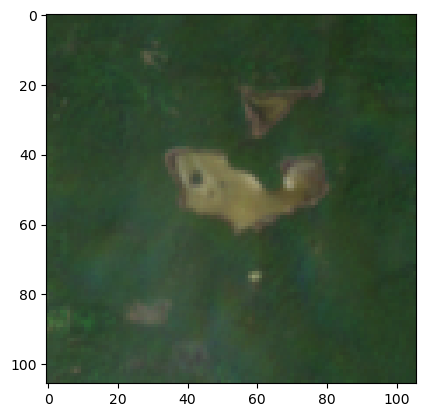

In [33]:
plt.imshow(np.transpose(cropped_img_array, axes=[1, 2, 0]))

# What about those Landsat images?

We kind of just dismissed the Landsat images in the previous section. Let's learn a little more about Landsat imagery and do some pre-processing to get these images to be more comparable to the Sentinel-2 images in terms of the underlying pixel values.

## Some Landsat background and analysis challenges

Landsat, a joint NASA/USGS program, provides the longest continuous space-based record of Earth’s land in existence.

There have been many Landsat missions since the original launch in 1972. The competition data only goes back to 2013, so participants should only use Landsat 8 and Landsat 9. Participants may not use any previous Landsat missions. Landsat 8 and Landsat 9 satellites are out of phase with one another, so that between the two each point on the Earth is revisited every 8 days. The data collected by Landsat 9 is very similar to Landsat 8.

Participants may use either level-1 or level-2 data, but may not use level-3. In addition to bottom-of-atmosphere reflectance, Landsat level-2 also includes a measurement of surface temperature, which is relevant to the behavior of algal blooms.

From https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

> Landsat Collection 2 Level-2 Science Products, consisting of atmospherically corrected surface reflectance and surface temperature image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present.
> 
> This dataset represents the global archive of Level-2 data from Landsat Collection 2 acquired by the Thematic Mapper onboard Landsat 4 and 5, the Enhanced Thematic Mapper onboard Landsat 7, and the Operatational Land Imager and Thermal Infrared Sensor onboard Landsat 8 and 9. Images are stored in cloud-optimized GeoTIFF format.




From the main tutorial:

> Note that unlike Sentinel-2 imagery, Landsat imagery is not originally returned with image values scaled to 0-255. Our function above scales the pixel values with cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX) so that it is more comparable to our Sentinel-2 imagery, and we can input both of them as features into our model. You may want to explore other methods of converting Sentinel and Landsat imagery to comparable scales to make sure that no information is lost when re-scaling.

## Exploring a Landsat image

We have a few Landsat images in the collection of items we found and they had pretty low cloud cover values. Let's get the one with the lowest cloud cover.

In [34]:
# 2 - take lowest cloud cover
best_item_landsat = (
    item_details_gdf[item_details_gdf.platform.str.contains("landsat")]
    .sort_values(by="cloud_cover", ascending=True)
    .iloc[0]
)
best_item_landsat

datetime                                                        2022-06-11
geometry                 POLYGON ((-85.1295869 45.6636126, -85.7045499 ...
platform                                                         landsat-8
cloud_cover                                                          36.88
min_long                                                        -85.735586
max_long                                                        -82.751318
min_lat                                                          43.514205
max_lat                                                          45.676265
bbox                     [-85.73558553, 43.51420503, -82.75131771, 45.6...
sample_point                  POINT (-83.30284787280465 45.03967636446461)
item_obj                         <Item id=LC08_L2SP_021029_20220611_02_T1>
contains_sample_point                                                 True
Name: 7, dtype: object

Again, the COG itself is in the `item_obj` column. The problem is that the assets that exist for Landsat COGs are slightly different than those for Sentinel-2.

In [35]:
for asset_key, asset in best_item_landsat.item_obj.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

qa                        - Surface Temperature Quality Assessment Band
ang                       - Angle Coefficients File
red                       - Red Band
blue                      - Blue Band
drad                      - Downwelled Radiance Band
emis                      - Emissivity Band
emsd                      - Emissivity Standard Deviation Band
trad                      - Thermal Radiance Band
urad                      - Upwelled Radiance Band
atran                     - Atmospheric Transmittance Band
cdist                     - Cloud Distance Band
green                     - Green Band
nir08                     - Near Infrared Band 0.8
lwir11                    - Surface Temperature Band
swir16                    - Short-wave Infrared Band 1.6
swir22                    - Short-wave Infrared Band 2.2
coastal                   - Coastal/Aerosol Band
mtl.txt                   - Product Metadata File (txt)
mtl.xml                   - Product Metadata File (xml)
mtl.json       

You can find a [good data dictionary at this MPC Landsat page](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2).

We aren't going to dig into all the details here, but instead will just focus on the issue raised in the original tutorial. The red, blue and green bands in the Landsat item are not scaled on a 0-255 scale. Here's the code from the original tutorial that uses the odc-stac and opencv libraries to normalize the red, blue and green bands to 0-255. A few things of note:

- the `odc.stac.stac_load()` function allows you to specify a list of bands to load
- the `cv2.normalize()` function is used to put the values on the 0-255 scale

```python
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array
```

Unfortunately, I had all kinds of problems getting odc-stac and opencv (includes the cv2 module) installed in my conda virtual environment. I figured instead of fighting with that, I'd figure out how to use rioxarray instead of odc-stac to load the bands into arrays and simply write my own normalize function to do the rescaling.

First, just to illustrate the scale problem, I'll load the red band.

In [36]:
red_href = best_item_landsat.item_obj.assets["red"].href
ds = rioxarray.open_rasterio(red_href)
ds

<xarray.DataArray (band: 1, y: 7761, x: 7641)>
[59301801 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.021e+05 6.021e+05 ... 8.313e+05 8.313e+05
  * y            (y) float64 5.059e+06 5.059e+06 ... 4.826e+06 4.826e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [37]:
ds[0, 4000:4005, 4000:4005].values

array([[8521, 8506, 8422, 8492, 8494],
       [8470, 8602, 8435, 8549, 8613],
       [8554, 8512, 8454, 8454, 8633],
       [8506, 8521, 8315, 8299, 8424],
       [8612, 8578, 8402, 8225, 8215]], dtype=uint16)

Yep, values aren't between 0-255.

I found that `rioxarray.open_rasterio` has the following input parameter:

- **band_as_variable (bool, default=False)** – If True, will load bands in a raster to separate variables.

Hmm, not sure that will work as we don't have a single raster file with all the bands. Instead we can load the red, green and blue bands separately, rescale them and then merge them.

Rescaling a vector of values to a new min and max is pretty easy.

    rescaled_value = new_min + (new_max - new_min) * (value - value.min) / (value.max - value.min)
    
Since our min is 0 and max is 255, this simplifies to:

    rescaled_value = 255 * (value - value.min) / (value.max - value.min)
    
There was a little numpy trickiness (see last line of code below).

In [ ]:
print(f'bbox\n{bbox}\n')
minx, miny, maxx, maxy = bbox

bands = {}
bands_rescaled = {}
for band in ['red', 'green', 'blue']:
    bands[band] = rioxarray.open_rasterio(best_item_landsat.item_obj.assets[band].href).rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
    )
    
    # Rescale to 0-255
    min_of_band = bands[band].min(dim=['x', 'y']).values
    max_of_band = bands[band].max(dim=['x', 'y']).values
    range_of_band = max_of_band - min_of_band
    bands_rescaled[band] = bands[band].copy()
    bands_rescaled[band].values = np.around(np.array([255]) * (bands[band].values - min_of_band) / range_of_band).astype('int')

In [ ]:
bands_rescaled['red'].values

Now let's combine the red, green, and blue bands to create the equivalent of the Sentinel-2 visual band. Now, we don't really *need* to do this for purposes of developing features for machine learning models, but it seems like a useful thing to know how to do and will let us directly compare the Landsat and Sentinel-2 images. The major steps we used are:

- create a list containing three `DataArray`s corresponding to the rescaled red, green and blue bands
- before adding each array to the list, add a band identifier as a coordinate
- combine the three `DataArray`s using `xarray.combine`

In [ ]:
for band in ['red', 'green', 'blue']:
    band_name = np.array([band])
    bands_rescaled[band] = bands_rescaled[band].assign_coords(band_name = ("band", band_name))
    # keep the unscaled version around for comparison
    bands[band] = bands[band].assign_coords(band_name = ("band", band_name))
    
bands_list = [val for key, val in bands_rescaled.items()]
bands_list

bands_list_unscaled = [val for key, val in bands.items()]

Combine the arrays into a single `DataArray`. 

In [ ]:
import xarray as xr

In [ ]:
bands_combined = xr.concat(bands_list, 'band')
bands_combined_unscaled = xr.concat(bands_list_unscaled, 'band')

Now we've got a single array we can crop and we have already normalized it.

In [ ]:
def crop_landsat_image(combined_xr, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    #image = odc.stac.stac_load(
    #    [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    #).isel(time=0)
    #image_array = image[["red", "green", "blue"]].to_array().to_numpy()
    
    cropped_image = combined_xr.rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return cropped_image



In [ ]:
landsat_image_array

In [ ]:
# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(bands_combined, bbox)
landsat_image_array_unscaled = crop_landsat_image(bands_combined_unscaled, bbox)
# Show the red band
landsat_image_array[0]

In [ ]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

I should probably revisit trying to get odc-stac and opencv installed in my conda virtual environment, but it was time well spent doing this manually - learned some xarray things that will be useful in the future.

## odc-stac update

I was reading another [official tutorial on reading Landsat data from MPC](https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/landsat-c2/landsat-c2-example.ipynb) and I saw how handy it was going to be to have odc-stac installed. And, I realized that my previous issue with installing [odc-stac](https://odc-stac.readthedocs.io/en/latest/) was almost certainly caused by some bad choices by me in mixing pip and conda installs. Just added odc-stac to my conda env (see Part 1) with:

    conda install -c conda-forge odc-stac
    
and everything still seems to be working just fine. Now, we could simply use the code (with a few changes) from the original tutorial to load the raster file and crop the image. I added in the normalizing code I wrote earlier in this tutorial. I'm also folding in some code from the tutorial I just mentioned that adds some additional bands to the mix.

In [ ]:
import odc.stac
def crop_landsat_image_odcstac(item, bounding_box, normalize=False):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as an xarray
    """
    (minx, miny, maxx, maxy) = bounding_box

    bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
    image = odc.stac.stac_load(
        [pc.sign(item)], bands=bands_of_interest, bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    
    if normalize:
        for band in ['red', 'green', 'blue']:
            min_of_band = image[band].min(dim=['x', 'y']).values
            max_of_band = image[band].max(dim=['x', 'y']).values
            range_of_band = max_of_band - min_of_band
            image[band].values =  np.around(np.array([255]) * (image[band].values - min_of_band) / range_of_band).astype('int')   

    return image

To plot the unscaled image, we need to include the `robust=True` argument, else matplotlib will ignore values outside of 0-255.

See [this page in the matplotlib docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow).

In [ ]:
# we'll use the same cropped area as above
landsat_image_array_odcstac = crop_landsat_image_odcstac(best_item_landsat.item_obj, bbox, normalize=False)
fig, ax = plt.subplots(figsize=(5, 5))
landsat_image_array_odcstac[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)

Here's the normalized version.

In [ ]:
# we'll use the same cropped area as above
landsat_image_array_odcstac = crop_landsat_image_odcstac(best_item_landsat.item_obj, bbox, normalize=True)
fig, ax = plt.subplots(figsize=(5, 5))
landsat_image_array_odcstac[["red", "green", "blue"]].to_array().plot.imshow(ax=ax)

## NDVI and Surface Temperature

Finally, since we added in some additional bands, we can do things such as computing NDVI and displaying that. From the MPC tutorial mentioned above:

> Landsat has several bands, and with them we can go beyond rendering natural color imagery; for example, the following code computes a [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using the near-infrared and red bands. Note that we convert the red and near infrared bands to a data type that can contain negative values; if this is not done, negative NDVI values will be incorrectly stored.

In [ ]:
red = landsat_image_array_odcstac["red"].astype("float")
nir = landsat_image_array_odcstac["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(7, 5))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("NDVI, Thunder Bay (MI)");

What if we wanted to add `ndvi` to the xarray as a new band?

In [ ]:
landsat_image_array_odcstac["ndvi"] = ndvi
landsat_image_array_odcstac

Finally, let's plot surface temperature (available via the `lwir11` key). According to the MPC tutorial:

> The raw values are rescaled, so you should scale and offset the data before interpreting it. Use the metadata in the asset's raster_bands to find the scale and offset values:

In [ ]:
band_info = best_item_landsat.item_obj.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

To go from raw values to Kelvin we do this (again, just following the MPC tutorial):

In [ ]:
temperature = landsat_image_array_odcstac["lwir11"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

In [ ]:
celsius = temperature - 273.15
celsius.plot(cmap="magma", size=5);

# A good place to stop for part 3

In this part we:

- Used the STAC API to search for images of interest in MPC based on a target location and target date,
- Used GeoPandas to manage the process of filtering out and finding the best image
- Used xarray to manually rescale Landsat bands to 0-255 scale.
- Got odc-stac installed and updated Landsat cropping procedure
- Plotted NDVI and Surface Temperature

In the next part, we'll focus on converting our imagery data to features that can be used in a machine learning model.